In [70]:
import os
import sys
from pathlib import Path
import importlib

import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the absolute path to ps_2_ex3_database directory (two levels up from current file)
notebook_path = Path().absolute()
repo_path = notebook_path.parent
data_path = repo_path / 'data'
sys.path.append(str(repo_path))
from nba import fitness
from nba import home_team
from nba import funfacts
importlib.reload(fitness)  # Ensure nba module is up-to-date
importlib.reload(home_team)  # Ensure nba module is up-to-date
importlib.reload(funfacts)  # Ensure nba module is up-to-date

<module 'nba.funfacts' from '/Users/congminhnguyen/MPhil Econs and Data Science/nba/ps_2_ex3_database/nba/funfacts.py'>

In [55]:
# Connect to SQLite database containing NBA data
# The database is located in the data directory and contains draft combine statistics
con = sql.connect(str(data_path/'nba.sqlite'))

# 1. Fun Facts!

In [71]:
funfacts.print_all_funfacts(con)


=== Top Countries with Most Players ===
USA: 3274 players
Canada: 35 players
France: 32 players
Serbia: 21 players
Croatia: 18 players

=== Height Extremes ===
Tallest: Kareem Abdul-Jabbar (7-2)
Shortest: Michael Adams (5-10)

=== Biggest Blowout ===
Date: 2021-12-02 00:00:00
Memphis Grizzlies vs Oklahoma City Thunder
Point Difference: 73.0

=== Most Common Matchups ===
Boston Celtics vs New York Knicks: 258 games
New York Knicks vs Boston Celtics: 257 games
Philadelphia 76ers vs Boston Celtics: 185 games
Boston Celtics vs Philadelphia 76ers: 183 games
Boston Celtics vs Detroit Pistons: 167 games


# 2. Fittest Positions!

In [56]:
query = """
    SELECT player_id, player_name, position, weight, height_wo_shoes, body_fat_pct
    FROM draft_combine_stats
"""
data = pd.read_sql_query(query, con)
data = data.dropna(subset=['weight', 'height_wo_shoes', 'body_fat_pct'])
data = data[data['position'] != ""]
data['body_fat_pct'] = pd.to_numeric(data['body_fat_pct'])
data['weight'] = pd.to_numeric(data['weight'])
data['BMI'] = fitness.calculate_bmi(data['weight'], data['height_wo_shoes'])

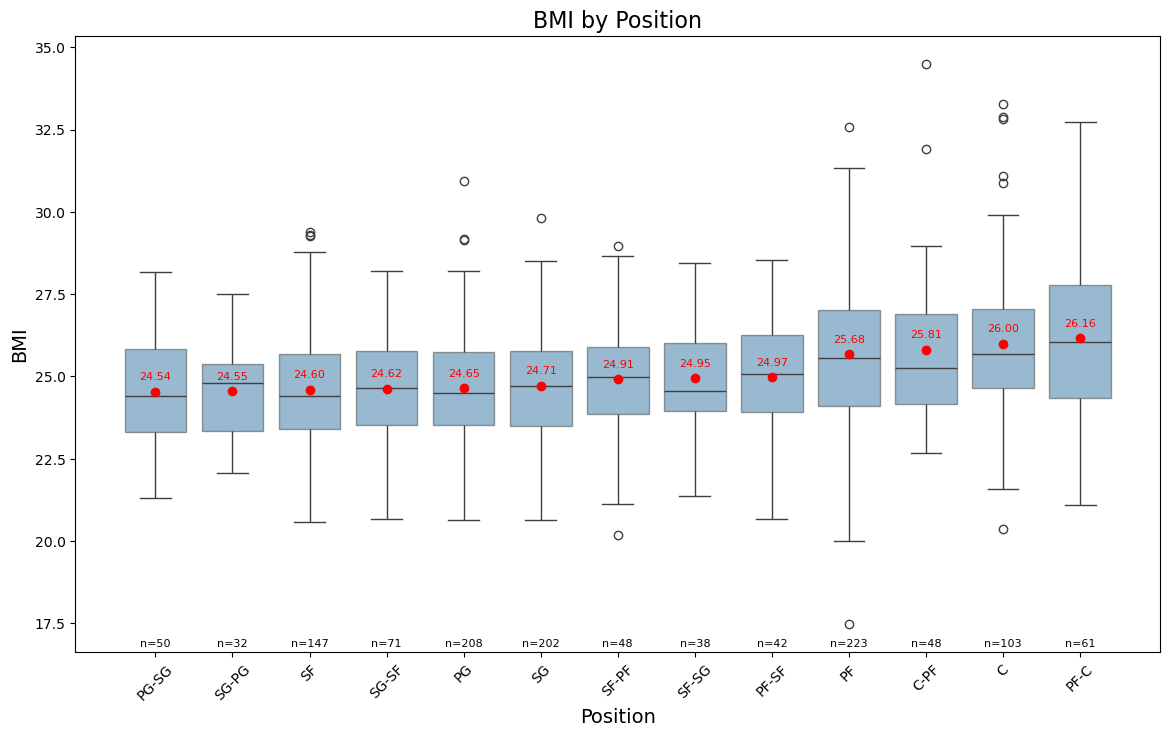

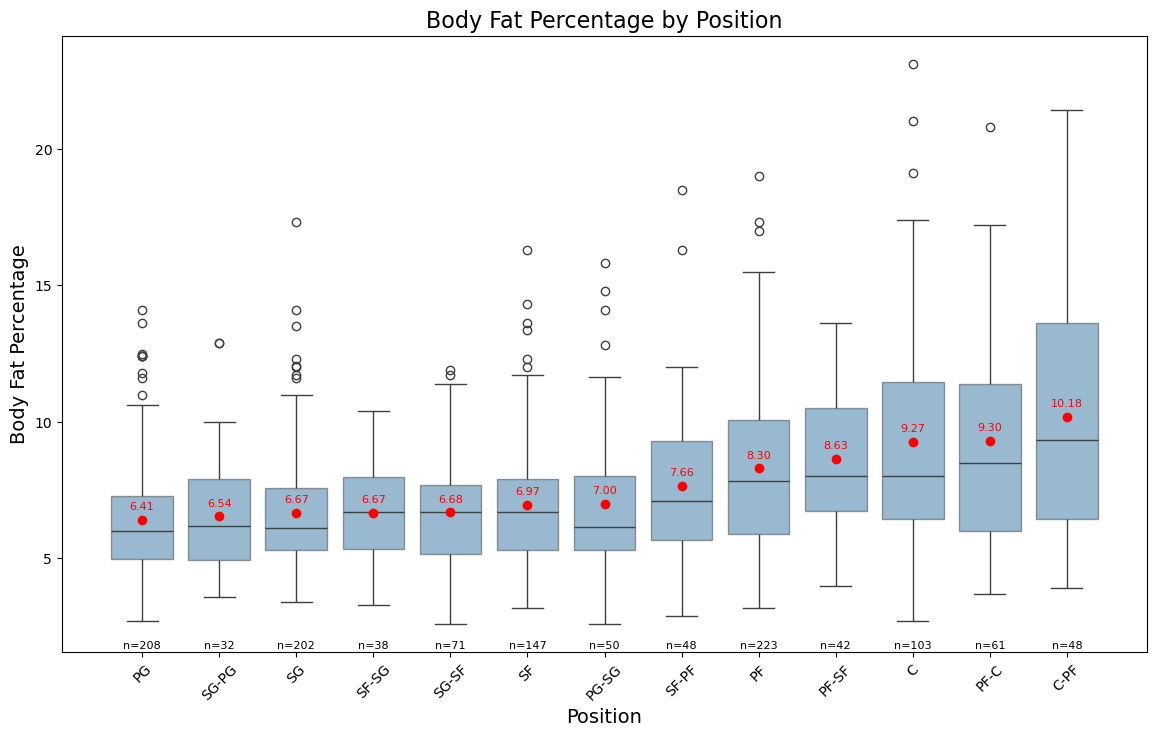

In [59]:
# Plot BMI by position
fitness.plot_metric_by_position(data, 'BMI', 'BMI by Position', 'BMI')

# Plot body fat percentage by position  
fitness.plot_metric_by_position(data, 'body_fat_pct', 'Body Fat Percentage by Position', 'Body Fat Percentage')


## Insights:
- Based on both BMI and body fat percentage, the PG (Point Guard) position appears to be the fittest in terms of leaness and agility (lower BMI and body fat percentage).
- The C (Center) and Power Forward (PF) positions are built for strength and physical presence (higher BMI and body fat percentage).

# 3. The Classic: Home Team Advantage!

In [65]:
# Query to get game data with additional stats
query = """
    SELECT g.*, 
           g.pts_home - g.pts_away as point_diff,
           gi.attendance,
           strftime('%w', g.game_date) as day_of_week
    FROM game g
    LEFT JOIN game_info gi ON g.game_id = gi.game_id
"""

# Execute query and process data
games_df = pd.read_sql(query, con)
games_df = home_team.prepare_game_data(games_df)

# Calculate statistics
yearly_stats = home_team.calculate_yearly_stats(games_df)
yearly_stats.columns = ['year', 'total_games', 'home_win_pct', 'avg_point_diff', 'point_diff_std']
day_stats = home_team.calculate_day_stats(games_df)


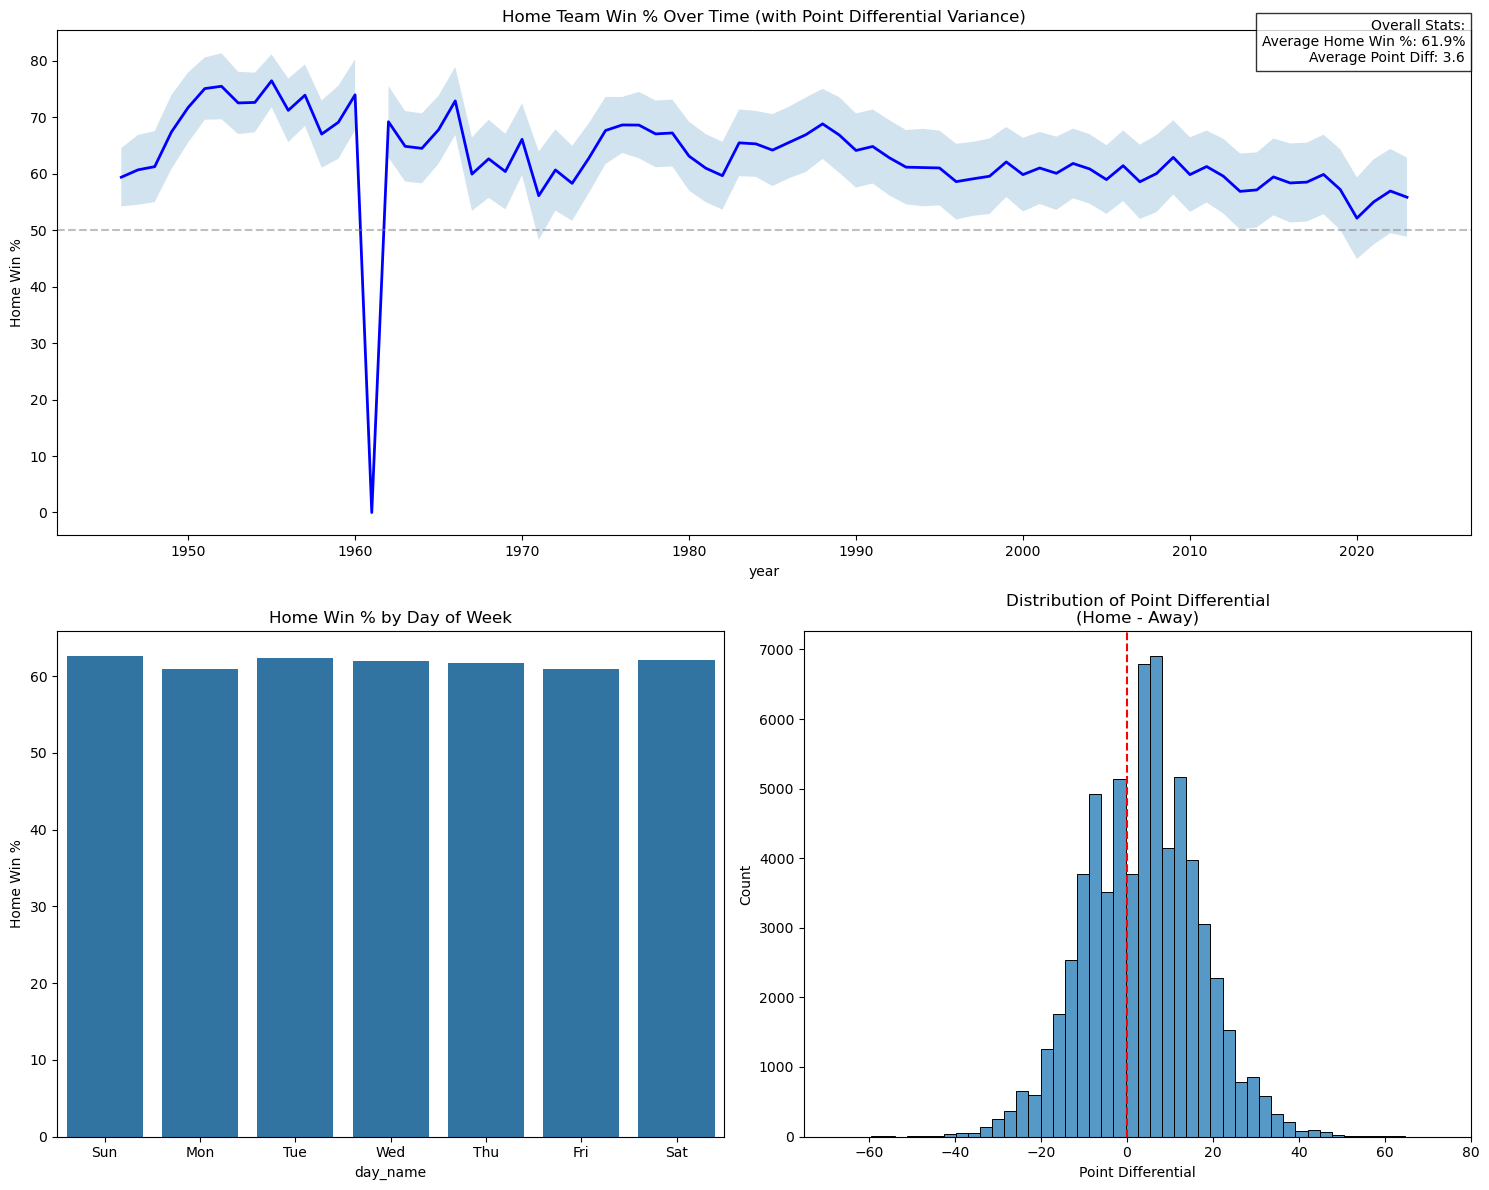

In [66]:
# Create visualization and get insights
fig, avg_home_win, avg_point_diff = home_team.plot_home_advantage(games_df, yearly_stats, day_stats)
plt.show()

## Insights:
- Home court advantage has remained relatively stable over time, averaging 61.9%
- Home teams score on average 3.6 more points than away teams
- Sun games show the highest home win % at 62.7%
- Fri games show the lowest home win % at 60.9%